In [1]:
# Importing the librares
import pandas as pd
from geopy.geocoders import Nominatim
import folium
import math

In [2]:
# Importing the customers data sheet and dropping values, where is no information
customers = pd.read_excel('kite_orders_data.xlsx','Customers')
customers.dropna(inplace=True)

In [3]:
# initiating the geolocator
geolocator = Nominatim(timeout=10, user_agent="PDS")

In [4]:
## Creating a new column of the first part of the post code and the delivery country
## Then dropping duplicated values to make the process faster, as geolocator runs for a while
#customers['Address'] = customers['DeliveryPostCode'].str.split(' ', expand = True)[0]+ ' ' + customers['DeliveryCountry']
#unique_addresses = customers['Address'].drop_duplicates()
#unique_addresses = unique_addresses.reset_index()
#unique_addresses = pd.DataFrame(unique_addresses)

## Applying geolocator function through the data set
#unique_addresses['geocode'] = unique_addresses['Address'].apply(geolocator.geocode)

## Dropping entries, which were not recognised , then extracting the latitude and longitude
#unique_addresses.dropna(inplace = True)
#unique_addresses['latitude'] = [g.latitude for g in unique_addresses.geocode]
#unique_addresses['longitude'] = [g.longitude for g in unique_addresses.geocode]

## Merging customer data the with extracted values
#customers_address = customers.merge(unique_addresses,how='left', on = 'Address')
#customers_address.dropna(inplace = True)

## It would take a while to run the geolocator, therefore the result is saved to an excel and loaded 
#customers_address.to_excel('customers_address.xlsx',index = False)
customers_address = pd.read_excel('customers_address.xlsx')

In [5]:
# Creating a tuple from the center distribution center's location
from geopy.distance import geodesic
coventry_center = geolocator.geocode('CV4 9AJ')
coventry_latitude = coventry_center.latitude
coventry_longitude = coventry_center.longitude
coventry = (coventry_latitude,coventry_longitude)

# Calculating the distance from the Coventry center for each address
customers_address['distance'] = customers_address.apply(lambda x: geodesic(coventry,(x.latitude, x.longitude)).miles, axis = 1) 
# Checking the summary statistics, there are some unusually high values which should be excluded
customers_address['distance'].describe()
customers_address = customers_address[customers_address['distance'] <= 3000]
customers_address['distance'].describe()

count    17252.000000
mean       101.167276
std         64.057062
min          1.084235
25%         64.399851
50%         89.525722
75%        120.193862
max        536.962615
Name: distance, dtype: float64

In [6]:
# Grouping the data by distance, the majority of the orders are falling within 200 miles,
# so it is worth it to test 50,100 and 200 miles radius
customers_address.groupby(pd.cut(customers_address['distance'],[0,50,100,200,300,400,500,600])).count()

,WebsiteID,DeliveryPostCode,DeliveryCountry,Address,index,geocode,latitude,longitude,distance
distance,,,,,,,,,
"(0, 50]",3161,3161,3161,3161,3161,3161,3161,3161,3161
"(50, 100]",7374,7374,7374,7374,7374,7374,7374,7374,7374
"(100, 200]",5191,5191,5191,5191,5191,5191,5191,5191,5191
"(200, 300]",1358,1358,1358,1358,1358,1358,1358,1358,1358
"(300, 400]",165,165,165,165,165,165,165,165,165
"(400, 500]",2,2,2,2,2,2,2,2,2
"(500, 600]",1,1,1,1,1,1,1,1,1


In [7]:
# Adding distance column to the orders data and deleting NAs such as deleted orders,
# or, when distance could not be calculated
orders = pd.read_excel('kite_orders_data.xlsx','Orders')
orders_merged = orders.merge(customers_address[['WebsiteID','distance','latitude','longitude']],on = 'WebsiteID',how = 'left')
orders_merged.dropna(subset = ['distance','DeliveryCost','DateDespatched'],inplace=True)
orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21579 entries, 0 to 24383
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   OrderID            21579 non-null  int64         
 1   WebsiteID          21579 non-null  int64         
 2   OrderDate          21579 non-null  datetime64[ns]
 3   StatusName         21579 non-null  object        
 4   StatusId           21579 non-null  int64         
 5   PaymentOptionName  21579 non-null  object        
 6   PaymentType        21579 non-null  int64         
 7   DespatchedCourier  21579 non-null  object        
 8   ProductsExVAT      21579 non-null  float64       
 9   DeliveryExVAT      21579 non-null  float64       
 10  VAT                21579 non-null  float64       
 11  SubTotal           21579 non-null  float64       
 12  GrandTotal         21579 non-null  float64       
 13  DateDespatched     21579 non-null  datetime64[ns]
 14  Delive

In [8]:
# Reading the order details sheet and creating a new column, which shows how much space is taken on a palet by every ordered item
orders_details = pd.read_excel('kite_orders_data.xlsx','Order Details')
orders_details['proportion_of_pallet'] = orders_details['Packs'] * orders_details['UnitsPerPack'] / orders_details['PalletQuantity']
orders_details['total_volume'] = orders_details['Packs'] * orders_details['UnitsPerPack'] * orders_details['CubicMPerUnit']
orders_details['whole_pallet'] = orders_details['proportion_of_pallet'].apply(lambda x:0 if math.isinf(x)  else x)
orders_details['whole_pallet'] = orders_details['whole_pallet'].apply(math.ceil)

In [9]:
pallet_items = orders_details[(orders_details['proportion_of_pallet']>= 0.5)].groupby(['OrderID'],as_index = False)[['whole_pallet','LineWeight']].sum()
small_items = orders_details[(orders_details['proportion_of_pallet']< 0.5)].groupby(['OrderID'],as_index = False)[['total_volume','LineWeight']].sum()
grouped_orders = pallet_items.merge(small_items, on = 'OrderID', how = 'outer',suffixes = ('_pallet', '_single'))
grouped_orders.fillna(0,inplace = True)

In [10]:
# Merging the data frames on OrderID to add the neccessery columns
# Then dropping rows, which could not be mapped earlier
delivery_details_merged = orders_details.merge(orders_merged[['OrderID','DateDespatched','distance','longitude','latitude','DeliveryExVAT','DeliveryCost',]],on = 'OrderID',how = 'left')
delivery_details_merged.dropna(subset = ('distance','DateDespatched'),inplace = True)

In [11]:
# Filtering down orders to within 50 miles and above 30 pounds. 30 pounds is the average delivery cost for orders
delivery_details_merged.DeliveryCost.describe()
in_house_delivery = delivery_details_merged[(delivery_details_merged['DeliveryCost']>30) &(delivery_details_merged['distance']<= 50)]

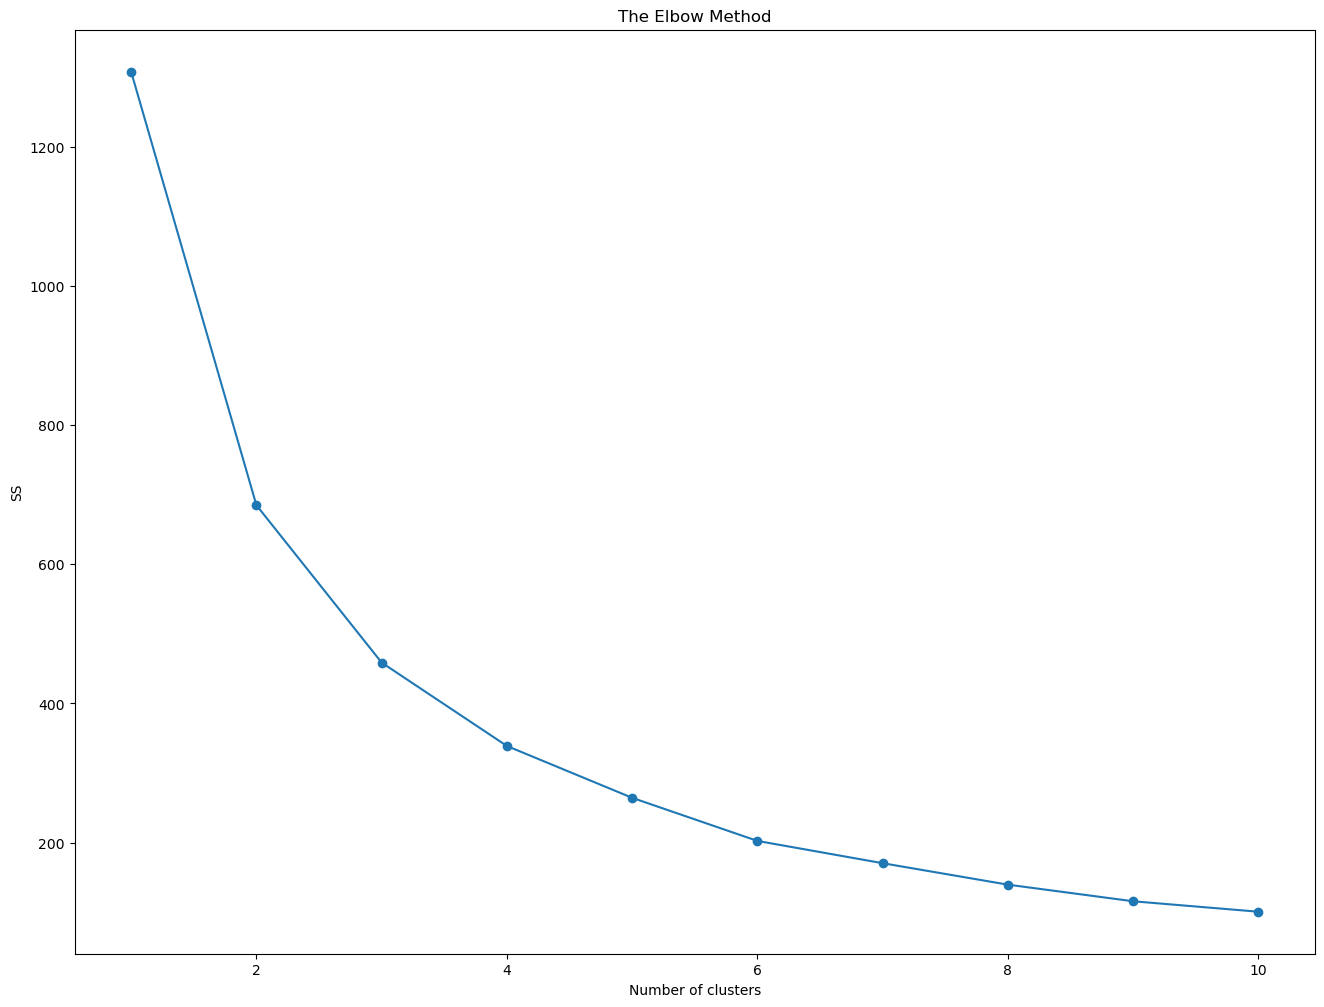

In [12]:
# Clustering the delivery addresses based on latitude and longitude
# Using elbow method three seems the optimal cluster number
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Elbow chart for us to decide on the number of optimal clusters.
ss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, max_iter = 500, n_init = 10, random_state = 42)
    kmeans.fit(in_house_delivery[['latitude','longitude']])
    ss.append(kmeans.inertia_)

# Plot the elbow and add labels, title.
fig, ax = plt.subplots()
fig.set_size_inches(16,12)
plt.plot(range(1,11),
        ss, marker = 'o')
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("SS")

plt.show()

In [13]:
# Fitting k-means cluster model and plotting on a map
kmeans = KMeans(n_clusters = 3,max_iter = 15000, init = 'k-means++', random_state = 42).fit(in_house_delivery[['latitude','longitude']])
in_house_delivery['K-Means Predicted'] = kmeans.labels_
import folium
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
     'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray' ]
lat = in_house_delivery.iloc[0]['latitude']
lng = in_house_delivery.iloc[0]['longitude']
map = folium.Map(location=[lng, lat], zoom_start=12)
for _, row in in_house_delivery.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=6, 
        weight=2, 
        fill=True, 
        fill_color=colors[int(row["K-Means Predicted"])],
        color=colors[int(row["K-Means Predicted"])]
    ).add_to(map)
map

C:\Users\tamas\AppData\Local\Temp\ipykernel_7604\311546324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_house_delivery['K-Means Predicted'] = kmeans.labels_


In [14]:
# Calculating how many vehicles are needed for deliver large goods (which takes more than a half pallet)
# Through the calculation it is assumed that 15 addresses could be covered by a single truck
in_house_delivery_pallet = in_house_delivery[in_house_delivery['proportion_of_pallet'] > 0.5]
day = []
total_combination = []
for i in range(len(in_house_delivery_pallet['DateDespatched'].unique())):
    day.append(in_house_delivery_pallet['DateDespatched'].unique()[i])
    zones = []
    for j in range(3):
        sorted_pallet = in_house_delivery_pallet[(in_house_delivery_pallet['DateDespatched'] == in_house_delivery_pallet['DateDespatched'].unique()[i]) \
                        & (in_house_delivery_pallet['K-Means Predicted'] == j)].sort_values(by = 'whole_pallet', ascending =False)
        
        large = 0
        medium = 0
        small = 0
        
        cost_large = 5400
        cost_medium = 4450
        cost_small = 3400
        
        for k in range(0,sorted_pallet.shape[0],15):
            one_delivery = ((sorted_pallet.iloc[k:k+15]['whole_pallet']).apply(math.ceil)).sum()
            large += math.floor(one_delivery/24)
            large_remainder = one_delivery % 24
            medium_need =  math.floor(large_remainder/14)
            if (cost_large/large_remainder) < (medium_need*cost_medium/large_remainder):
                large += 1
                large_remainder = 0
            medium += math.floor(large_remainder/14)
            medium_remainder = large_remainder % 14
            small_need =  math.floor(medium_remainder/2)
            if (cost_medium/medium_remainder) < (small_need*cost_small/medium_remainder):
                medium += 1
                medium_remainder = 0
            small += math.ceil(medium_remainder/2)
        combination = [large,medium,small,j,in_house_delivery_pallet['DateDespatched'].unique()[i]]
        zones.append(combination)
    total_combination.append(zones)

pallet_needs = pd.DataFrame()
for i in range(len(total_combination)):
    a = pd.DataFrame(total_combination[i],columns = ['L','M','S','Zone','Date'])
    pallet_needs = pd.concat((pallet_needs,a))
pallet_needs = pallet_needs.groupby(['Date','Zone']).sum()
pallet_needs['Cost'] = pallet_needs['L'] *5400 + pallet_needs['M'] * 4450 + pallet_needs['S'] * 3400

C:\Users\tamas\AppData\Local\Temp\ipykernel_7604\1883042598.py:26: RuntimeWarning: divide by zero encountered in longlong_scalars
  if (cost_large/large_remainder) < (medium_need*cost_medium/large_remainder):
C:\Users\tamas\AppData\Local\Temp\ipykernel_7604\1883042598.py:26: RuntimeWarning: invalid value encountered in longlong_scalars
  if (cost_large/large_remainder) < (medium_need*cost_medium/large_remainder):
C:\Users\tamas\AppData\Local\Temp\ipykernel_7604\1883042598.py:32: RuntimeWarning: divide by zero encountered in longlong_scalars
  if (cost_medium/medium_remainder) < (small_need*cost_small/medium_remainder):
C:\Users\tamas\AppData\Local\Temp\ipykernel_7604\1883042598.py:32: RuntimeWarning: invalid value encountered in longlong_scalars
  if (cost_medium/medium_remainder) < (small_need*cost_small/medium_remainder):


In [15]:
# Using the similar algorithm but focus on those orders which are smaller (under 0.5 pallet)

in_house_delivery_small = in_house_delivery[in_house_delivery['proportion_of_pallet'] < 0.5]
in_house_delivery_small.dropna(inplace = True)
day = []
total_combination = []
for i in range(len(in_house_delivery_small['DateDespatched'].unique())):
    day.append(in_house_delivery_small['DateDespatched'].unique()[i])
    zones = []
    for j in range(3):
        sorted_pallet = in_house_delivery_small[(in_house_delivery_small['DateDespatched'] == in_house_delivery_small['DateDespatched'].unique()[i]) \
                        & (in_house_delivery_small['K-Means Predicted'] == j)].sort_values(by = 'total_volume',ascending =False)
        
        large = 0
        medium = 0
        small = 0
        
        cost_large = 5400
        cost_medium = 4450
        cost_small = 3400
        
        for k in range(0,sorted_pallet.shape[0],15):
            one_delivery = ((sorted_pallet.iloc[k:k+15]['total_volume']).apply(math.ceil)).sum()
            large += math.floor(one_delivery/45)
            large_remainder = one_delivery % 45
            medium_need =  math.floor(large_remainder/25)
            if (cost_large/large_remainder) < (medium_need*cost_medium/large_remainder):
                large += 1
                large_remainder = 0
            medium += math.floor(large_remainder/25)
            medium_remainder = large_remainder % 25
            small_need =  math.floor(medium_remainder/2.5)
            if (cost_medium/medium_remainder) < (small_need*cost_small/medium_remainder):
                medium += 1
                medium_remainder = 0
            small += math.ceil(medium_remainder/2.5)
        combination = [large,medium,small,j,in_house_delivery_small['DateDespatched'].unique()[i]]
        zones.append(combination)
    total_combination.append(zones)
    
small_needs = pd.DataFrame()
for i in range(len(total_combination)):
    a = pd.DataFrame(total_combination[i],columns = ['L','M','S','Zone','Date'])
    small_needs = pd.concat((small_needs,a))
small_needs = small_needs.groupby(['Date','Zone']).sum()
small_needs['Cost'] = small_needs['L'] *5400 + small_needs['M'] * 4450 + small_needs['S'] * 3400

C:\Users\tamas\AppData\Local\Temp\ipykernel_7604\1241498649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_house_delivery_small.dropna(inplace = True)


In [16]:
pallet_cost = pallet_needs.groupby('Date').sum().mean()
small_cost = small_needs.groupby('Date').sum().mean()

In [17]:
# On average 1,18 tonne, 13, 7.5 tonne and 2 3.5 tonne trucks are needed
# Their monthly cost would be slightly above the current delivery costs
small_cost + pallet_cost

L           0.818182
M          13.104545
S           2.100000
Cost    69873.409091
dtype: float64

In [18]:
# Amount is currently paid for delivery by Kite for the observed orders
in_house_delivery.drop_duplicates('OrderID')['DeliveryCost'].sum()

64821.259999999995